In [32]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint


In [33]:
# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef


In [34]:
# Define the U-Net model with additional layers
def unet_model(input_size=(224, 224, 3)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)  # New pooling layer added

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)  # New convolution layer added
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)  # New convolution layer added
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)  # New pooling layer added

    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)  # Increased filter size
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder (Upsampling)
    up1 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    merge1 = layers.concatenate([conv4, up1], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge1)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up2 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge2 = layers.concatenate([conv3, up2], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge2)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up3 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge3 = layers.concatenate([conv2, up3], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up4 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge4 = layers.concatenate([conv1, up4], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge4)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    output = layers.Conv2D(1, 1, activation='sigmoid')(conv9)  # Ensure sigmoid for binary masks

    model = models.Model(inputs=[inputs], outputs=[output])
    return model


In [35]:
# Compile the model with custom metrics
def compile_model_with_custom_metrics(model):
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=binary_crossentropy,
                  metrics=[
                      'accuracy',  # Standard accuracy metric
                      tf.keras.metrics.MeanIoU(num_classes=2, name='mean_io_u'),
                      DiceMetric(),  # Custom Dice
                      IoUMetric(),   # Custom IoU
                      tf.keras.metrics.Precision(name='precision'), 
                      tf.keras.metrics.Recall(name='recall')
                  ])
    return model


In [36]:
# Load data function
def load_data(image_dir='data_aug/jpg_aug', mask_dir='data_aug/mask_aug', img_size=(224, 224)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
            
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)
            images.append(image)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype(np.float32)  # Convert to binary and float32
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            masks.append(mask)

    return np.array(images), np.array(masks)


In [37]:
# Visualize samples
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Remove the channel dimension for masks
        plt.title('Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

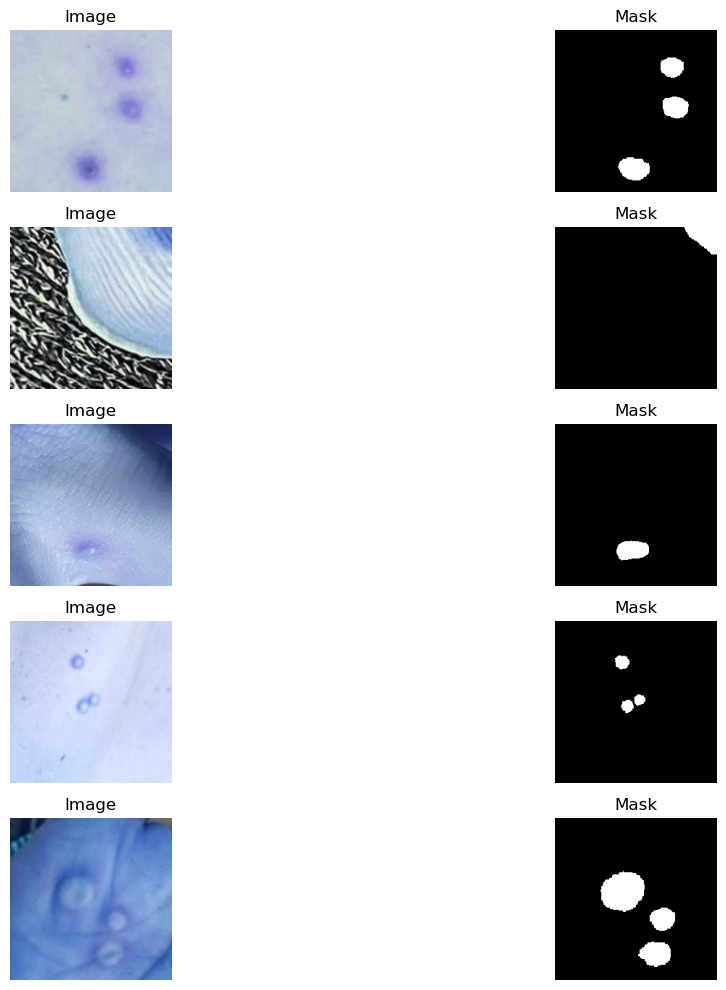

In [39]:
# Load data
x_train, y_train = load_data()

# Visualize a few samples
visualize_samples(x_train, y_train)

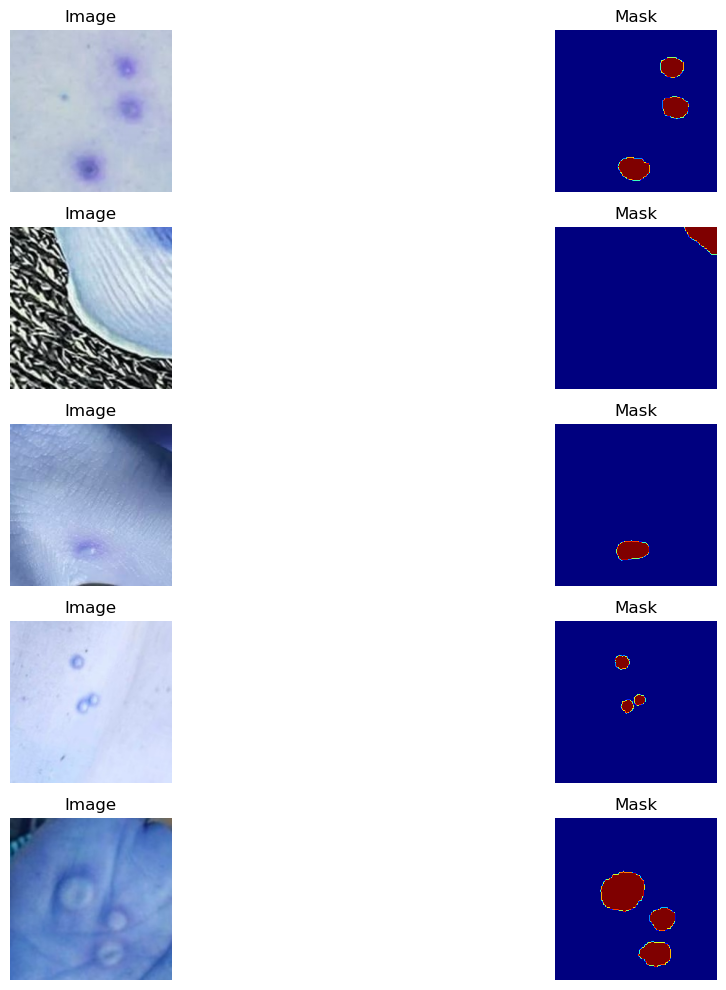

In [40]:
# Visualize samples with colorful masks
def visualize_samples(images, masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[i].squeeze(), cmap='jet')  # Use the 'jet' colormap for colorful masks
        plt.title('Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
# Load data
x_train, y_train = load_data()

# Visualize a few samples
visualize_samples(x_train, y_train)

In [48]:
# Function to train the U-Net model with model saving
def train_unet(x_train, y_train, model, model_name, batch_size=4, epochs=70):
    # Define a ModelCheckpoint callback to save the best model
    checkpoint = ModelCheckpoint(f"best_{model_name}.keras", 
                                 monitor='val_loss',  # Monitor validation loss
                                 verbose=1,           # Print messages when saving the model
                                 save_best_only=True,  # Save only the best model
                                 mode='min')           # Save the model with minimum validation loss
    
    # Train the model with the ModelCheckpoint callback
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        validation_split=0.2, 
                        callbacks=[checkpoint])
    
    # Save model history (optional since best model is saved by checkpoint)
    np.save(f"{model_name}_history.npy", history.history)
    
    return model, history


In [49]:
unet_custom.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 224, 224,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 112, 112,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 28,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 14, 14,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 28, 28,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 28, 28,    │          0 │ conv2d_26[0][0],

 Total params: 93,095,237 (355.13 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,063,492 (236.75 MB)

In [ ]:
# Load data
x_train, y_train = load_data()

# Create Model 1: U-Net with custom Dice, IoU, Precision, Recall
unet_custom = unet_model()
unet_custom = compile_model_with_custom_metrics(unet_custom)
unet_custom, history_custom = train_unet(x_train, y_train, unet_custom, "unet_custom")


Epoch 1/70


/home/salman/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_64']. Received: the structure of inputs=*
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8849 - dice_coef: 0.0692 - iou_coef: 0.0372 - loss: 0.5646 - mean_io_u: 0.4690 - precision: 0.0747 - recall: 0.0520
Epoch 1: val_loss improved from inf to 0.28206, saving model to best_unet_custom.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.8853 - dice_coef: 0.0696 - iou_coef: 0.0375 - loss: 0.5620 - mean_io_u: 0.4690 - precision: 0.0754 - recall: 0.0519 - val_accuracy: 0.9227 - val_dice_coef: 0.0932 - val_iou_coef: 0.0497 - val_loss: 0.2821 - val_mean_io_u: 0.4616 - val_precision: 0.1401 - val_recall: 0.0012
Epoch 2/70
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9352 - dice_coef: 0.1257 - iou_coef: 0.0690 - loss: 0.2145 - mean_io_u: 0.4687 - precision: 0.3868 - recall: 0.0536
Epoch 2: val_loss improved from 0.28206 to 0.22926, saving model to best_unet_custom.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.9351 - dice_coef: 0.1259 - iou_coef: 0.0691 - loss: 0.2145 - mean_io_u: 0.4687 - precision: 0

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(unet_standard, to_file='unet_model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


## for the unet structure check ensembled folder

In [2]:
# Function to plot all relevant metrics
def plot_training_history(history):
    plt.figure(figsize=(18, 12))

    # Plot loss
    plt.subplot(3, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(3, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Mean IoU if available
    if 'mean_io_u' in history:
        plt.subplot(3, 2, 3)
        plt.plot(history['mean_io_u'], label='Train Mean IoU')
        plt.plot(history['val_mean_io_u'], label='Validation Mean IoU')
        plt.title('Mean IoU Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plot Dice Coefficient if available
    if 'dice_metric' in history:
        plt.subplot(3, 2, 4)
        plt.plot(history['dice_metric'], label='Train Dice Coefficient')
        plt.plot(history['val_dice_metric'], label='Validation Dice Coefficient')
        plt.title('Dice Coefficient Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Coefficient')
        plt.legend()
    
    # Plot Precision if available
    if 'precision' in history:
        plt.subplot(3, 2, 5)
        plt.plot(history['precision'], label='Train Precision')
        plt.plot(history['val_precision'], label='Validation Precision')
        plt.title('Precision Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

    # Plot Recall if available
    if 'recall' in history:
        plt.subplot(3, 2, 6)
        plt.plot(history['recall'], label='Train Recall')
        plt.plot(history['val_recall'], label='Validation Recall')
        plt.title('Recall Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_training_history(history_custom.history)


NameError: name 'history_custom' is not defined

In [3]:
import matplotlib.pyplot as plt

def visualize_predictions(model, x, y, num_images=5):
    # Get predictions
    predictions = model.predict(x)
    
    # Set up the plot
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Call the visualization function after training
visualize_predictions(unet_custom, x_train, y_train)


NameError: name 'unet_custom' is not defined

In [ ]:
# Load the saved U-Net model
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': dice_coef, 'iou_coef': iou_coef})  # Ensure to define or import dice_coef and iou_coef if custom metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved U-Net model
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path)

def visualize_predictions(model, x, y, num_images=5):
    # Get predictions
    predictions = model.predict(x)
    
    # Set up the plot
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load example data (x and y) from numpy files or another source
# Assuming x_data.npy and y_data.npy are available and contain your images and masks
x_data = np.load("path/to/x_data.npy")  # Replace with the actual path
y_data = np.load("path/to/y_data.npy")  # Replace with the actual path

# Visualize predictions
visualize_predictions(unet_model, x_data, y_data)


14/14 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step


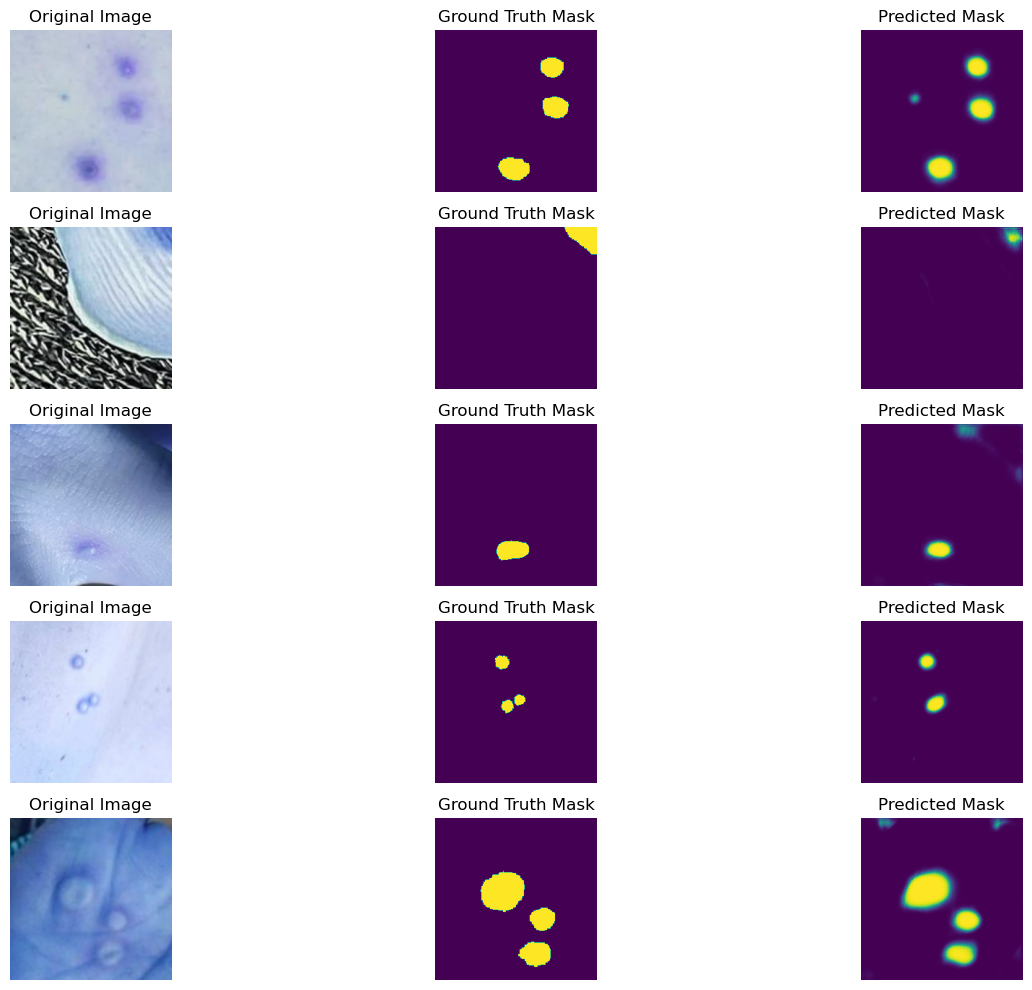

In [25]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


# Load data function
def load_data(image_dir='data_aug/jpg_aug', mask_dir='data_aug/mask_aug', img_size=(224, 224)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
            
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)
            images.append(image)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype(np.float32)  # Convert to binary and float32
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            masks.append(mask)

    return np.array(images), np.array(masks)


# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Rest of your code (loading data, visualization, etc.)
# Example visualization function if needed
def visualize_predictions(model, x, y, num_images=5):
    predictions = model.predict(x)
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x[i].squeeze())
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y[i].squeeze())
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze())
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load example data (replace load_data function as per your dataset)
# visualize_predictions(unet_model, x_data, y_data) # Example usage if needed
# Load example data
x_data, y_data = load_data()

# Visualize predictions
visualize_predictions(unet_model, x_data, y_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


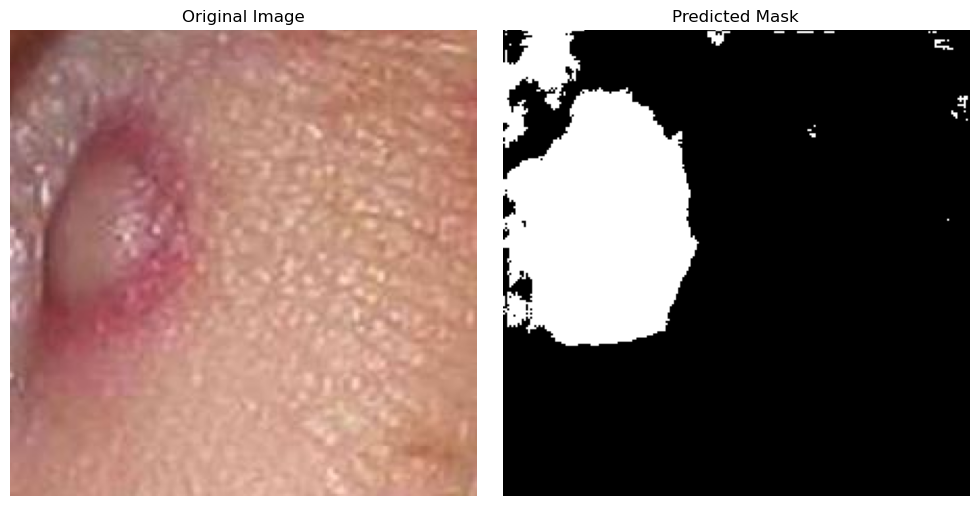

In [35]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to load and preprocess an external image
def load_and_preprocess_image(image_path, img_size=(224, 224)):
    # Load the image
    image = cv2.imread(image_path)
    
    # Resize the image
    image = cv2.resize(image, img_size)
    
    # Normalize the image
  #  image = image.astype('float32') / 255.0
    
    # Add batch dimension
    image = np.expand_dims(image, axis=0)  # Shape: (1, height, width, channels)
    
    return image

# Function to visualize the original image and predicted mask
def visualize_prediction(original_image, predicted_mask):
    plt.figure(figsize=(10, 5))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    
    # Predicted Mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask.squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Load your trained U-Net model
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Load and preprocess the external image
image_path = "mkp_093.jpg"  # Specify your image path here
input_image = load_and_preprocess_image(image_path)

# Make predictions
predicted_mask = unet_model.predict(input_image)

# Post-process the predicted mask (e.g., thresholding)
predicted_mask = (predicted_mask > 0.1).astype(np.uint8)  # Convert to binary mask

# Visualize the original image and predicted mask
original_image = cv2.imread(image_path)  # Load original image for visualization
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
visualize_prediction(original_image, predicted_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


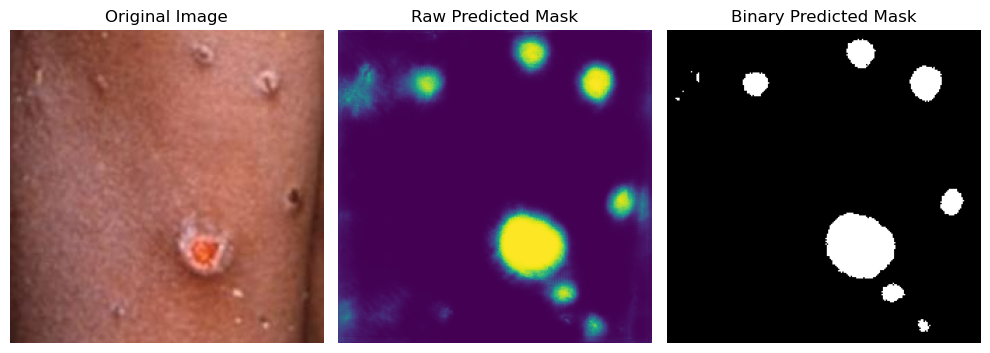

In [30]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)
   # image = image / 255.0  # Normalize to [0, 1] if required
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Apply threshold to get binary mask
    threshold = 0.5  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_078.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw,)
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
Predicted Mask Raw Shape: (1, 224, 224, 1)
Predicted Mask Raw Values (sample): [0.05439173 0.12401417 0.0977527  0.08464821 0.0750095  0.07633631
 0.07820407 0.09201454 0.08709694 0.10366296]


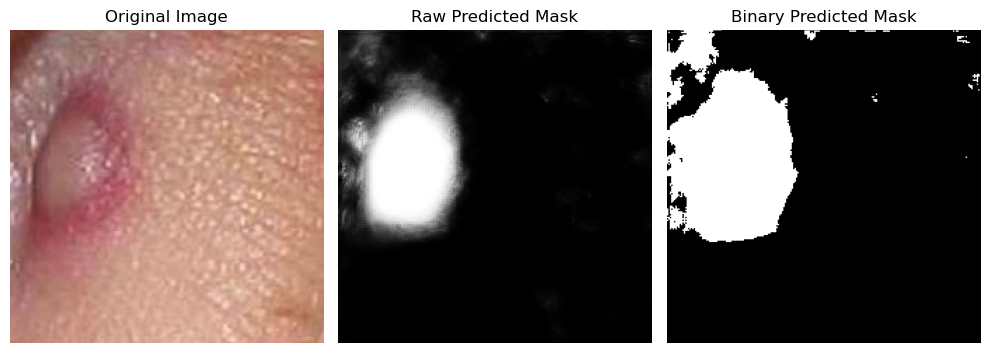

In [31]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    image = cv2.resize(image, img_size)
  #  image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Print the predicted mask raw shape and some values for debugging
    print("Predicted Mask Raw Shape:", predicted_mask_raw.shape)
    print("Predicted Mask Raw Values (sample):", predicted_mask_raw[0].flatten()[:10])  # Print first 10 values

    # Apply threshold to get binary mask
    threshold = 0.1  # Adjust if necessary
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Predict on a single image
image_path = 'mkp_093.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw, cmap='gray')
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Predicted Mask Raw Shape: (1, 224, 224, 1)
Predicted Mask Raw Values (sample): [0.05439173 0.12401417 0.0977527  0.08464821 0.0750095  0.07633631
 0.07820407 0.09201454 0.08709694 0.10366296]


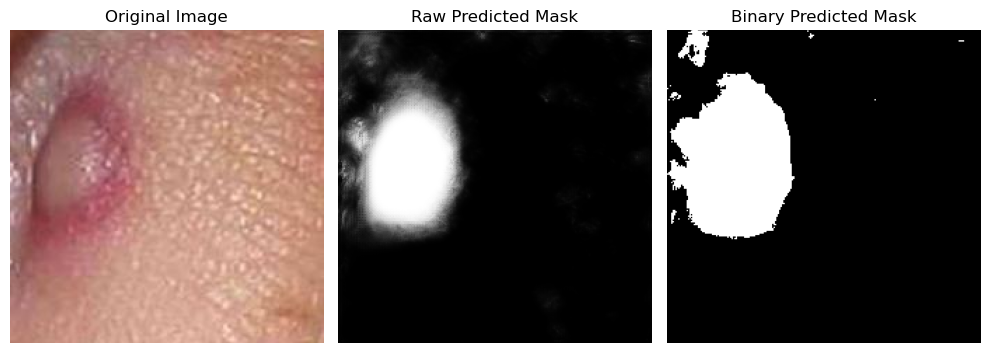

In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Register custom metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())


def iou_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

# Load a single image function
def load_single_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    image = cv2.resize(image, img_size)
    #image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict mask for a single image
def predict_mask(model, image_path):
    # Load and preprocess the image
    image_input = load_single_image(image_path)

    # Predict the mask
    predicted_mask_raw = model.predict(image_input)

    # Print the predicted mask raw shape and some values for debugging
    print("Predicted Mask Raw Shape:", predicted_mask_raw.shape)
    print("Predicted Mask Raw Values (sample):", predicted_mask_raw[0].flatten()[:10])  # Print first 10 values

    # Apply threshold to get binary mask
    threshold = 0.2  # Adjusted threshold for better segmentation
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    return predicted_mask_raw[0], predicted_mask_binary

# Load the saved U-Net model
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': dice_coef, 'iou_coef': iou_coef})

# Predict on a single image
image_path = 'mkp_093.jpg'  # Define your image path here
predicted_mask_raw, predicted_mask_binary = predict_mask(unet_model, image_path)

# Visualize the results
def visualize_single_prediction(original_image_path, predicted_mask_raw, predicted_mask_binary):
    # Load the original image for visualization
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_raw, cmap='gray')
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask_binary, cmap='gray')
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the predictions
visualize_single_prediction(image_path, predicted_mask_raw, predicted_mask_binary)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


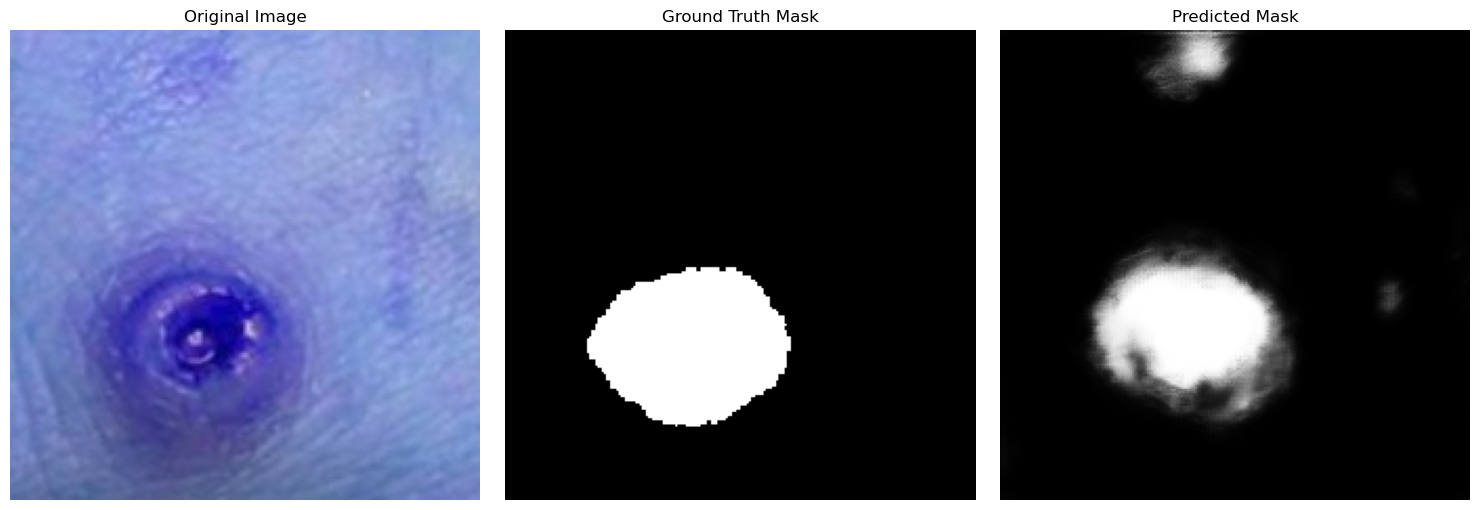

In [36]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt


# Load data function
def load_data(image_dir='data_aug/jpg_aug', mask_dir='data_aug/png_aug', img_size=(224, 224)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
            
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)
            images.append(image)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype(np.float32)  # Convert to binary and float32
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            masks.append(mask)

    return np.array(images), np.array(masks)


# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Function to visualize predictions for a specific image
def visualize_single_prediction(model, image_path, mask_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) # / 255.0  # Resize and normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Load the ground truth mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (224, 224))
    mask = (mask > 0).astype(np.float32)  # Convert to binary
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    # Predict the mask
    predicted_mask = model.predict(image)

    # Visualize the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image[0])  # Original Image
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')  # Ground Truth Mask
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[0].squeeze(), cmap='gray')  # Predicted Mask
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage: Provide the paths to the image and mask
image_path = 'data_aug/jpg_aug/mkp_018_aug_1.jpg'  # Replace with your image path
mask_path = 'data_aug/mask_aug/mkp_018_aug_1.png'  # Replace with your mask path
visualize_single_prediction(unet_model, image_path, mask_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


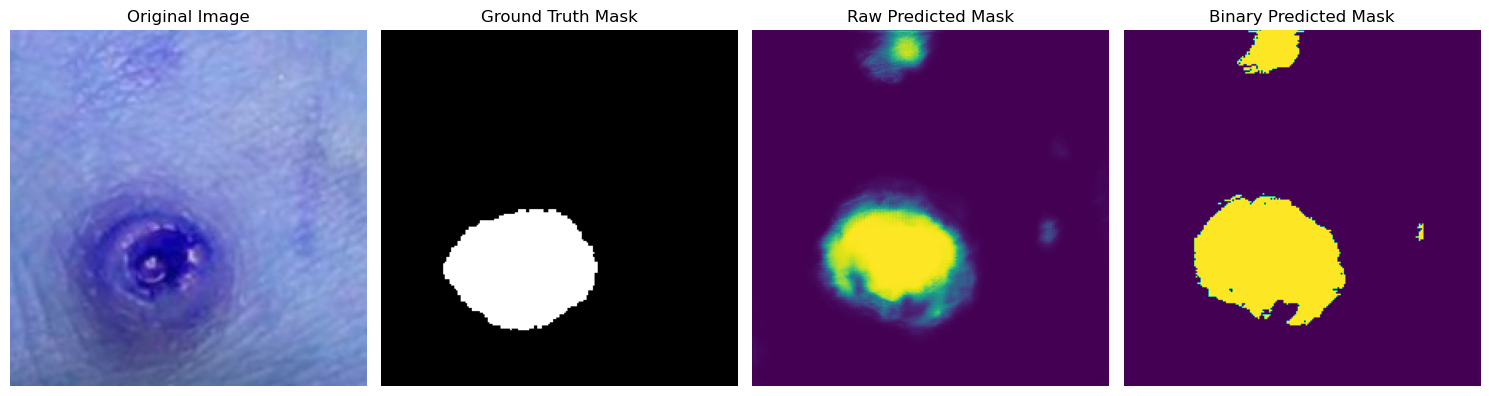

In [28]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load data function
def load_data(image_dir='data_aug/jpg_aug', mask_dir='data_aug/png_aug', img_size=(224, 224)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
            
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)
            images.append(image)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype(np.float32)  # Convert to binary and float32
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            masks.append(mask)

    return np.array(images), np.array(masks)

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Function to visualize predictions for a specific image
def visualize_single_prediction(model, image_path, mask_path):
    # Load the image
    image = cv2.imread(image_path)
    #image = cv2.resize(image, (224, 224)) / 255.0  # Resize and normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Load the ground truth mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (224, 224))
    mask = (mask > 0).astype(np.float32)  # Convert to binary
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

    # Predict the mask
    predicted_mask_raw = model.predict(image)

    # Apply a lower threshold for binary mask
    threshold = 0.2  # You can experiment with this value
    predicted_mask_binary = (predicted_mask_raw[0] > threshold).astype(np.uint8)

    # Visualize the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(image[0])  # Original Image
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mask.squeeze(), cmap='gray')  # Ground Truth Mask
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(predicted_mask_raw[0].squeeze())  # Raw Predicted Mask
    plt.title("Raw Predicted Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(predicted_mask_binary.squeeze())  # Predicted Binary Mask
    plt.title("Binary Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage: Provide the paths to the image and mask
image_path = 'data_aug/jpg_aug/mkp_018_aug_1.jpg' # Replace with your image path
mask_path = 'data_aug/mask_aug/mkp_018_aug_1.png'  # Replace with your mask path
visualize_single_prediction(unet_model, image_path, mask_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


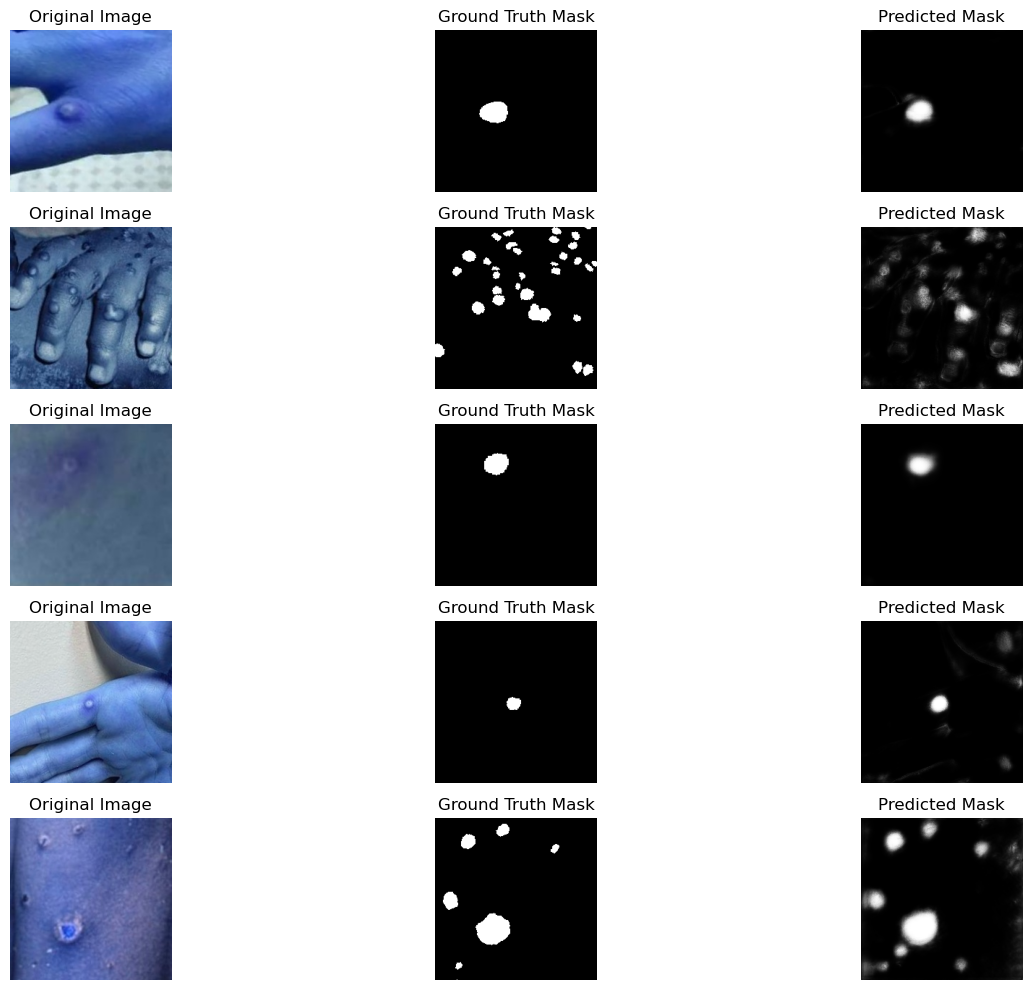

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load data function
def load_data(image_dir='data_aug/jpg_aug', mask_dir='data_aug/mask_aug', img_size=(224, 224)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '.png'))
            
            # Load and resize images
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)
           # image = image / 255.0  # Normalize to [0, 1]
            images.append(image)

            # Load and preprocess masks
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype(np.float32)  # Convert to binary and float32
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            masks.append(mask)

    return np.array(images), np.array(masks)

# Custom Dice coefficient
def DiceMetric():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
        return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)
    return dice_coef

# Custom IOU Metric
def IoUMetric():
    def iou_coef(y_true, y_pred):
        intersection = tf.keras.backend.sum(y_true * y_pred)
        union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
        return (intersection + 1e-6) / (union + 1e-6)
    return iou_coef

# Load the saved U-Net model with custom_objects for dice_coef and iou_coef
model_path = "best_unet_custom.keras"
unet_model = load_model(model_path, custom_objects={'dice_coef': DiceMetric(), 'iou_coef': IoUMetric()})

# Function to visualize predictions
def visualize_predictions(model, x, y, num_images=5):
    predictions = model.predict(x)
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Load example data
x_data, y_data = load_data()

# Randomly select images to visualize predictions
random_indices = np.random.choice(len(x_data), size=5, replace=False)
x_random = x_data[random_indices]
y_random = y_data[random_indices]

# Visualize predictions on random images
visualize_predictions(unet_model, x_random, y_random)
